In [1]:
import os
import numpy as np
import sagemaker
from sagemaker.session import s3_input

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [2]:
hyperparams={    'epochs': 30,
                 'learning-rate': 0.01,
                 'batch-size': 256,
                 'weight-decay': 2e-4,
                 'momentum': 0.9,
                 'optimizer': 'sgd'}

In [3]:
from sagemaker.tensorflow import TensorFlow

output_path = 's3://sagemaker-container-webinar/'
tf_estimator = TensorFlow(entry_point='cifar10-training-script-sagemaker.py', 
                          source_dir='code',
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.p3.2xlarge',
                          framework_version='1.13', 
                          py_version='py3',
                          script_mode=True,
                          output_path=output_path,
                          hyperparameters=hyperparams)

train_path = 's3://sagemaker-container-webinar/cifar10-dataset/train'
val_path = 's3://sagemaker-container-webinar/cifar10-dataset/validation'
eval_path = 's3://sagemaker-container-webinar/cifar10-dataset/eval'

In [4]:
tf_estimator.fit({'training': train_path,'validation': val_path,'eval': eval_path})

2019-08-09 01:17:40 Starting - Starting the training job...
2019-08-09 01:17:42 Starting - Launching requested ML instances.........
2019-08-09 01:19:14 Starting - Preparing the instances for training......
2019-08-09 01:20:28 Downloading - Downloading input data
2019-08-09 01:20:28 Training - Downloading the training image...
2019-08-09 01:21:07 Training - Training image download completed. Training in progress..
2019-08-09 01:21:11,861 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-08-09 01:21:12,289 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "eval": "/opt/ml/input/data/eval",
        "training": "/opt/ml/input/data/training",
        "validation": "/opt/ml/input/data/validation"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hype

In [21]:
predictor = tf_estimator.deploy(initial_instance_count=1, instance_type='ml.c5.large')

W0809 04:47:28.131635 140550900488000 session.py:729] Using already existing model: tensorflow-training-2019-08-09-01-17-40-386


---------------------------------------------------------------------------------------!

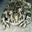

sample-img/1009_frog.png


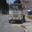

sample-img/1008_truck.png


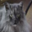

sample-img/1014_cat.png


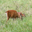

sample-img/1003_deer.png


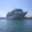

sample-img/1004_ship.png


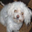

sample-img/1000_dog.png


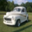

sample-img/1005_automobile.png


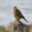

sample-img/1038_bird.png


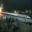

sample-img/1001_airplane.png


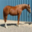

sample-img/1037_horse.png


In [22]:
from IPython.display import Image, display

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
images = []
for entry in os.scandir('sample-img'):
    if entry.is_file() and entry.name.endswith("png"):
        images.append('sample-img/' + entry.name)

for image in images:
    display(Image(image))
    print(image)

In [23]:
predictor.content_type = 'application/x-image'
predictor.serializer = None

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def get_prediction(file_path, pred_obj):
    
    with open(file_path, "rb") as image:
        f = image.read()
    b = bytearray(f)
    return labels[np.argmax(pred_obj.predict(b)['predictions'], axis=1)[0]]


In [31]:
predictions = [get_prediction(image, predictor) for image in images]

print('Predictions','\t\t\t','Actual')
for pred, actual in zip(predictions,images):
    print(pred,'    \t',actual)

Predictions 			 Actual
frog     	 sample-img/1009_frog.png
ship     	 sample-img/1008_truck.png
cat     	 sample-img/1014_cat.png
deer     	 sample-img/1003_deer.png
ship     	 sample-img/1004_ship.png
dog     	 sample-img/1000_dog.png
automobile     	 sample-img/1005_automobile.png
bird     	 sample-img/1038_bird.png
airplane     	 sample-img/1001_airplane.png
horse     	 sample-img/1037_horse.png


In [34]:
tf_estimator.delete_endpoint()

In [13]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {
    'learning-rate': ContinuousParameter(0.0001, 0.1, scaling_type='Logarithmic'), 
    'batch-size':    CategoricalParameter([32, 128, 512, 1024]),
    'momentum':      ContinuousParameter(0.9, 0.99),
    'optimizer':     CategoricalParameter(['sgd', 'adam'])
}

objective_metric_name = 'val_acc'
objective_type = 'Maximize'
metric_definitions = [{'Name': 'val_acc', 'Regex': 'val_acc: ([0-9\\.]+)'}]

tuner = HyperparameterTuner(tf_estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            strategy='Random',
                            max_jobs=16,
                            max_parallel_jobs=8,
                            objective_type=objective_type)

In [14]:
tuner.fit({'training': train_path,'validation': val_path,'eval': eval_path})

In [32]:
tuner_predictor = tuner.deploy(initial_instance_count=1, 
                               instance_type='ml.c5.large',
                               accelerator_type='ml.eia1.medium')

2019-08-09 03:11:53 Starting - Preparing the instances for training
2019-08-09 03:11:53 Downloading - Downloading input data
2019-08-09 03:11:53 Training - Training image download completed. Training in progress.
2019-08-09 03:11:53 Uploading - Uploading generated training model
2019-08-09 03:11:53 Completed - Training job completed

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0151191/1250 [===========================>..] - ETA: 3s - loss: 0.0757 - acc: 0.9751#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0151192/1250 [===========================>..] - ETA: 3s - loss: 0.0757 - acc: 0.9751#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



---------------------------------------------------------------------------------------!

In [33]:
tuner_predictor.content_type = 'application/x-image'
tuner_predictor.serializer = None

predictions = [get_prediction(image, tuner_predictor) for image in images]

print('Predictions','\t\t\t','Actual')
for pred, actual in zip(predictions,images):
    print(pred,'    \t',actual)

Predictions 			 Actual
frog     	 sample-img/1009_frog.png
truck     	 sample-img/1008_truck.png
cat     	 sample-img/1014_cat.png
deer     	 sample-img/1003_deer.png
ship     	 sample-img/1004_ship.png
dog     	 sample-img/1000_dog.png
automobile     	 sample-img/1005_automobile.png
bird     	 sample-img/1038_bird.png
airplane     	 sample-img/1001_airplane.png
horse     	 sample-img/1037_horse.png


In [35]:
tuner_predictor.delete_endpoint()